# Post processing and visualizing mandyoc data

The following notebook allows the user to visualize a given mandyoc output (e.g.: `'temperature'`, `'strain_rate'`, `'lithology'`, etc) according to a given number of time instants (e.g.: `instants = [0, 10, 20, 30]` Myr. `len(instants)` must be >= 2.

For a given instant in the `instants` the script will find the closest time step to this instant and plot the respective output.

In [4]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import os
import sys
import pylab as pl
import xarray as xr
import pymp
import mpl_toolkits.axisartist
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import string

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

sys.path.insert(0, f"{machine_path}/opt/scripts/functions")
from mandyocIO import read_datasets, change_dataset, plot_property, find_nearest, plot_tracked_particles, plot_ptt_paths

# How to plot

## In the following cell, you must inform:
 - The path to your `scenario` without `/OS_home/username` because this is collected by `machine_path`.
     - Ex.: `/mandyoc/experiments/my_experiment/`
 - The mandyoc property `prop` that you want to visualize uncommenting one the commented options.
     - `prop = 'lithology'` is the default.
 - The values in list `instants` containing the instants that you want to visualize.
     - Ex: `instants = [0, 10, 20, 30]` #Myr

In [10]:
#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/Volumes/{external_media}"

v = 1
# v = 2

if(v==1):
    scenarios = [
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v1/RFT_DT230_Tp1350oC_crust40km_v1_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v1/RFT_DT230_Tp1350oC_crust40km_v1_Clc10_checkered_false",

            ]
    time_crustal_breakbups = [26.00,
                              17.67,
                              28.40,
                              20.00,
                              33.19,
                              25.00]
    

    time_lithospheric_breakbups = [12.85, # this is for complete breakup
                                   24.78,
                                   12.82,
                                   26.28,
                                   15.99,
                                   36.87]
    
    # time_lithospheric_breakbups = [11.70, #this is for the lithospheric mantle breakup
    #                                17.63,
    #                                7.31,
    #                                13.32,
    #                                15.99,
                                #    24.55]
    
if(v==2):
    scenarios = [
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc10_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc10_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v2/RFT_DT230_Tp1350oC_crust40km_v2_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v2/RFT_DT230_Tp1350oC_crust40km_v2_Clc10_checkered_false",
                ]
    
    time_crustal_breakbups = [12.91,
                              10.74,
                              12.12,
                              9.18,
                              16.70,
                              11.68]
        
    time_lithospheric_breakbups = [5.50,
                                   8.98,
                                   6.06,
                                   9.64,
                                   6.00,
                                   12.26]

    # time_lithospheric_breakbups = [5.00,
    #                                8.00,
    #                                3.31,
    #                                6.11,
    #                                6.00,
    #                                10.50]

trackdataset0 = xr.open_dataset(f"{scenarios[0]}/_track_xzPT_all_steps.nc")
trackdataset1 = xr.open_dataset(f"{scenarios[1]}/_track_xzPT_all_steps.nc")
trackdataset2 = xr.open_dataset(f"{scenarios[2]}/_track_xzPT_all_steps.nc")
trackdataset3 = xr.open_dataset(f"{scenarios[3]}/_track_xzPT_all_steps.nc")
trackdataset4 = xr.open_dataset(f"{scenarios[4]}/_track_xzPT_all_steps.nc")
trackdataset5 = xr.open_dataset(f"{scenarios[5]}/_track_xzPT_all_steps.nc")

print(f"Plotting scenarios with v = {v} cm/yr")

Plotting scenarios with v = 1 cm/yr


Tt_Pt_evolution_v1_depth_coded


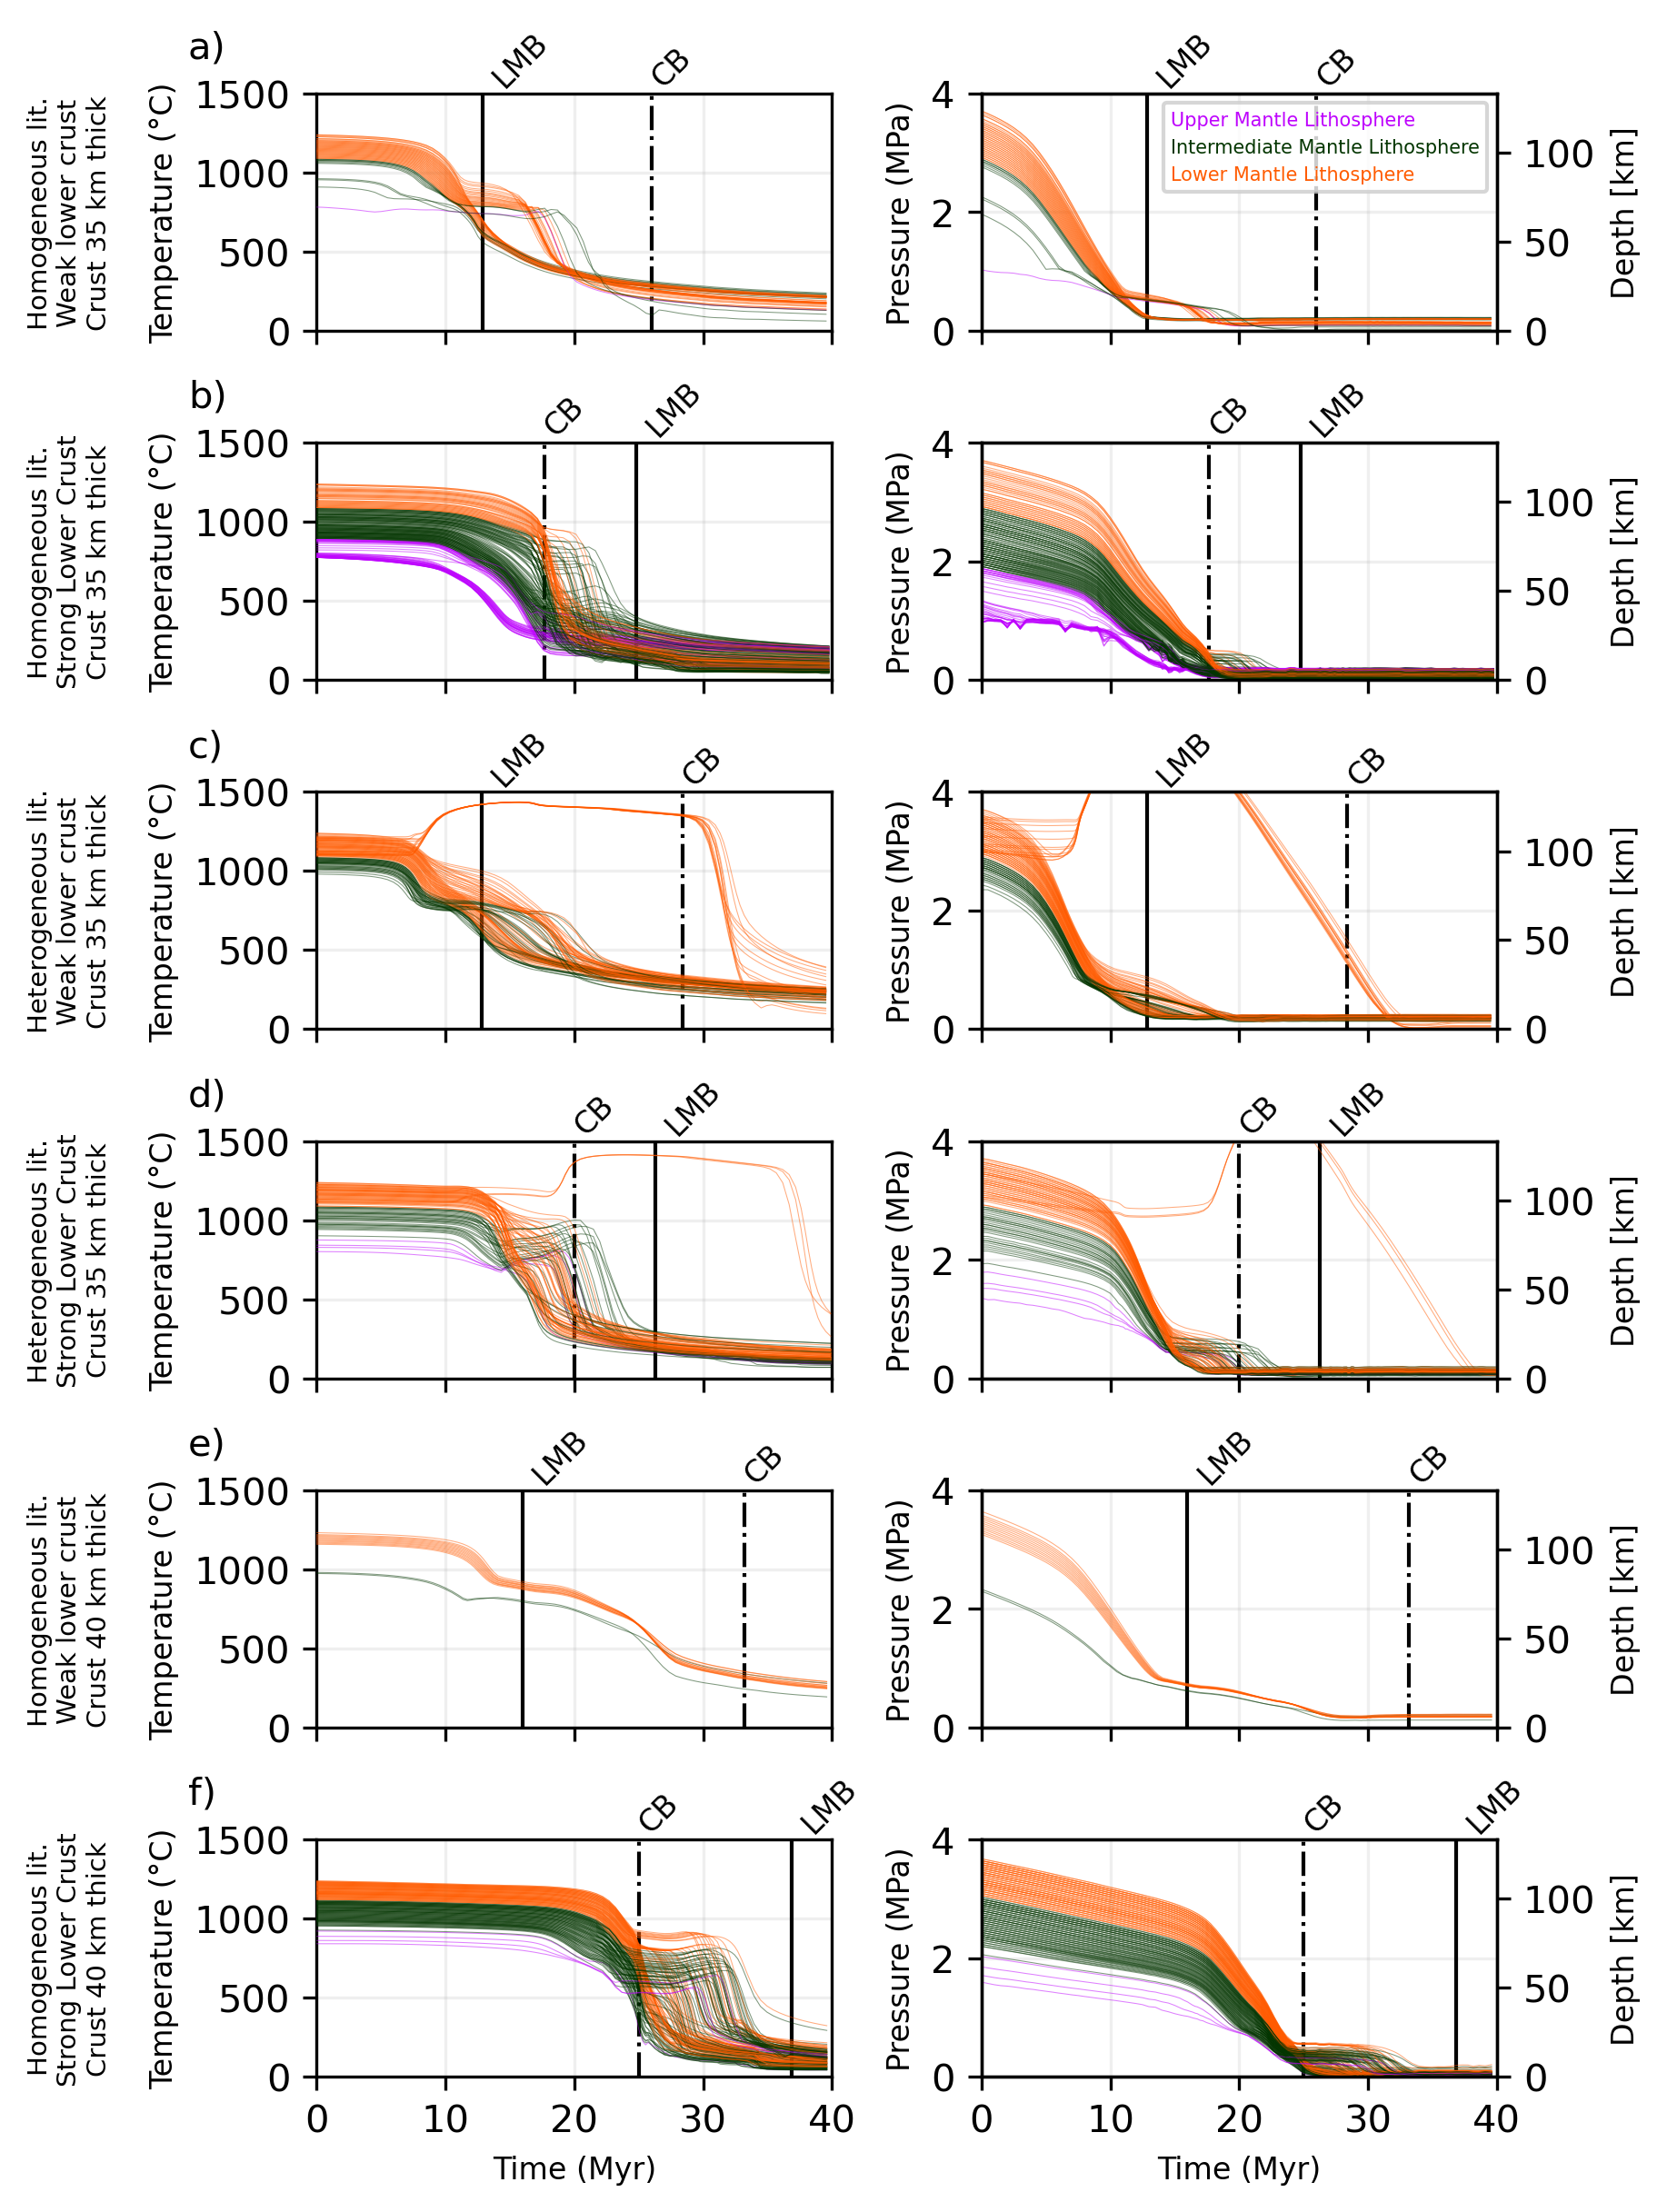

In [11]:
def take_three_particles(layer_codes, particles_layers, T_initial):
    if(len(layer_codes) == 1):
        cond = particles_layers == layer_codes[0]
    else:
        cond = (particles_layers == layer_codes[0]) | (particles_layers == layer_codes[1])

    particles_layer = particles_layers[cond]
    
    T_initial_layer = T_initial[cond] #initial temperature of lithospheric mantle particles

    T_initial_layer_sorted = np.sort(T_initial_layer)

    Ti_layer_max = np.max(T_initial_layer_sorted)
    mid_index = len(T_initial_layer_sorted)//2
    Ti_layer_mid = T_initial_layer_sorted[mid_index]
    Ti_layer_min = np.min(T_initial_layer_sorted)

    cond2plot = (T_initial == Ti_layer_min) | (T_initial == Ti_layer_mid) | (T_initial == Ti_layer_max)

    return cond2plot, cond, Ti_layer_max, Ti_layer_mid, Ti_layer_min, len(particles_layer)

def plot_PT_evolution(axT, axP, time, P, T, color='xkcd:light gray', linewidth=1, markersize=2, alpha=1.0, zorder=60, plot_each_5Myr=True, marker='.'):
    axT.plot(time, T[::, particle], '-', color=color, linewidth=linewidth, alpha=alpha, zorder=zorder) #PTt path
    axP.plot(time, P[::, particle], '-', color=color, linewidth=linewidth, alpha=alpha, zorder=zorder) #PTt path

    if(plot_each_5Myr == True):
        for j in np.arange(0, time[-1], 2):
            idx = find_nearest(time, j)
            axT.plot(time[idx], T[idx, particle], marker, color=color, markersize=markersize, zorder=zorder)
            axP.plot(time[idx], P[idx, particle], marker, color=color, markersize=markersize, zorder=zorder)

trackdatasets = [trackdataset0, trackdataset1, trackdataset2, trackdataset3, trackdataset4, trackdataset5]#, trackdataset6, trackdataset7]

asthenosphere_code = 0 #asthenosphere
mantle_lithosphere1_code = 1
mantle_lithosphere2_code = 3 #lithospheric mantle
lower_crust_code = 4 #lower crust
upper_crust_code = 5 #upper crust

linewidth = 0.85
markersize = 3.5
color_lower_crust='xkcd:brown'
color_mlit_upper='xkcd:bright purple'#'xkcd:cerulean blue'
color_mlit_intermediate='xkcd:dark green'#'xkcd:scarlet'
color_mlit_lower='xkcd:bright orange'#'xkcd:dark green'

fig, axs = plt.subplots(6, 2 , figsize=(6, 8), dpi=300, constrained_layout=True, sharex=True)
# fig, axs = plt.subplots(4, 2 , figsize=(8, 8), dpi=150, constrained_layout=True, sharex=True)
axs = axs.flatten()
ylims = np.array([0, 4]) #for pressure plots
ylims_temperature = np.array([0, 1500]) #for temperature plots
xlims = np.array([0, 40]) if v==1 else np.array([0, 40])
plot_each_5Myr = False
for trackdataset, tc, tl, i in zip(trackdatasets, time_crustal_breakbups, time_lithospheric_breakbups, range(len(trackdatasets))):
    x_track = trackdataset.xtrack.values[::-1]
    z_track = trackdataset.ztrack.values[::-1]
    P = trackdataset.ptrack.values[::-1]
    T = trackdataset.ttrack.values[::-1]
    time = trackdataset.time.values[::-1]
    steps = trackdataset.step.values[::-1]
    n = int(trackdataset.ntracked.values)
    nTotal = np.size(x_track)
    steps = nTotal//n #number of steps

    x_track = np.reshape(x_track,(steps,n))
    z_track = np.reshape(z_track,(steps,n))
    P = np.reshape(P,(steps,n))
    T = np.reshape(T,(steps,n))
    particles_layers = trackdataset.particles_layers.values[::-1] #code of the tracked layer

    T_initial = T[0] #initial temperature of particles
    P_initial = P[0] #initial pressure of particles
    z_initial = z_track[0]

    h_air = 40.0e3 #m
    h_lithosphere = 120.0e3 #m
    #thickness of mantle lithosphere sections
    thickness_upper = 30.0e3
    thickness_intermediate = 30.0e3

    hcrust = 40.0e3 if ((i == 4) or (i == 5)) else 35.0e3 #m. Crustal thickness
    thickness_lower = h_lithosphere - (hcrust + thickness_upper + thickness_intermediate)

    zb_crust_and_air = -1.0 * (hcrust + h_air) #m z depth of the bottom of the crust considering air layer
    zb_upper = zb_crust_and_air - thickness_upper #m. The values of z_initial are negative, so we need to subtract
    zb_intermediate = zb_upper - thickness_intermediate #m. The values of z_initial are negative, so we need to subtract
    zb_lower = -1.0 * (h_lithosphere + h_air) #m z depth of the bottom of the lithosphere considering air layer

    if(asthenosphere_code in particles_layers):
        cond_upper_2plot_ast = (P_initial <= 4000) & (z_initial < zb_crust_and_air) & (z_initial >= zb_upper) #condition for upper particles - the values of z_initial are negative, so the logical condition is inverted
        cond_intermediate_2plot_ast = (P_initial <= 4000) & (z_initial < zb_upper) & (z_initial >= zb_intermediate) #condition for intermediate particles
        cond_lower_2plot_ast = (P_initial <= 4000) & (z_initial < zb_intermediate) & (z_initial >= zb_lower) #condition for lower particles
        plot_asthenosphere_particles = True
        
    else:
        plot_asthenosphere_particles = False
        cond_ast2plot = np.arange(0, n, 1) == np.arange(0, n, 1) + 1

    if((mantle_lithosphere1_code in particles_layers) | (mantle_lithosphere2_code in particles_layers)):
        cond_upper_2plot_mlit = (z_initial < zb_crust_and_air) & (z_initial >= zb_upper) #condition for upper particles - the values of z_initial are negative, so the logical condition is inverted
        cond_intermediate_2plot_mlit = (z_initial < zb_upper) & (z_initial >= zb_intermediate) #condition for intermediate particles
        cond_lower_2plot_mlit = (z_initial < zb_intermediate) & (z_initial >= zb_lower) #condition for lower particles

        plot_mantle_lithosphere_particles = True
    else:
        plot_mantle_lithosphere_particles = False
        cond_mantle_lithosphere2plot = np.arange(0, n, 1) == np.arange(0, n, 1) + 1

    if(lower_crust_code in particles_layers):
        cond_lower_crust2plot, cond_lower_crust, Ti_crust_max, Ti_crust_mid, Ti_crust_min, n_lower_crust = take_three_particles([lower_crust_code],
                                                                                                particles_layers, T_initial)

        # print(f"N crustal particles: {n_lower_crust}")

        dict_lower_crust_markers = {Ti_crust_max: '*',
                                    Ti_crust_mid: '^',
                                    Ti_crust_min: 'D'}

        plot_lower_crust_particles = False

    else:
        plot_lower_crust_particles = False
        cond_lower_crust2plot = np.arange(0, n, 1) == np.arange(0,n,1) + 1

    plot_other_particles = True #plot particles that are not in the other categories

    linewidth = 0.25
    for particle, particle_layer in zip(range(n), particles_layers):
                #Plot particles in prop subplot
        if((plot_lower_crust_particles == True) & (particle_layer == lower_crust_code)):
            if(cond_lower_crust2plot[particle] == True):
                marker = dict_lower_crust_markers[T_initial[particle]]
                plot_PT_evolution(axs[2*i], axs[2*i+1], time, P/1.0e3, T, color=color_lower_crust, linewidth=linewidth, markersize=markersize, zorder=61, plot_each_5Myr=plot_each_5Myr, marker='.')

        if((plot_mantle_lithosphere_particles == True) & ((particle_layer == mantle_lithosphere1_code) | (particle_layer == mantle_lithosphere2_code))):
            if(cond_upper_2plot_mlit[particle] == True):
                plot_PT_evolution(axs[2*i], axs[2*i+1], time, P/1.0e3, T, color=color_mlit_upper, linewidth=linewidth, markersize=markersize, alpha=0.5, zorder=60, plot_each_5Myr=plot_each_5Myr)
            if(cond_intermediate_2plot_mlit[particle] == True):
                plot_PT_evolution(axs[2*i], axs[2*i+1], time, P/1.0e3, T, color=color_mlit_intermediate, linewidth=linewidth, markersize=markersize, alpha=0.5, zorder=60, plot_each_5Myr=plot_each_5Myr)
            if(cond_lower_2plot_mlit[particle] == True):
                plot_PT_evolution(axs[2*i], axs[2*i+1], time, P/1.0e3, T, color=color_mlit_lower, linewidth=linewidth, markersize=markersize, alpha=0.5, zorder=60, plot_each_5Myr=plot_each_5Myr)

        if((plot_asthenosphere_particles == True) & (particle_layer == asthenosphere_code)):
            if(cond_upper_2plot_ast[particle] == True):
                plot_PT_evolution(axs[2*i], axs[2*i+1], time, P/1.0e3, T, color=color_mlit_upper, linewidth=linewidth, markersize=markersize, alpha=0.5, zorder=60, plot_each_5Myr=plot_each_5Myr)
            if(cond_intermediate_2plot_ast[particle] == True):
                plot_PT_evolution(axs[2*i], axs[2*i+1], time, P/1.0e3, T, color=color_mlit_intermediate, linewidth=linewidth, markersize=markersize, alpha=0.5, zorder=60, plot_each_5Myr=plot_each_5Myr)
            if(cond_lower_2plot_ast[particle] == True):
                plot_PT_evolution(axs[2*i], axs[2*i+1], time, P/1.0e3, T, color=color_mlit_lower, linewidth=linewidth, markersize=markersize, alpha=0.5, zorder=60, plot_each_5Myr=plot_each_5Myr)

    axs[2*i].plot([tc, tc], ylims_temperature, '-.', color='xkcd:black', linewidth=1, zorder=59) #crustal breakup time
    axs[2*i].plot([tl, tl], ylims_temperature, '-', color='xkcd:black', linewidth=1, zorder=59) #lithospheric breakup time
    axs[2*i].text(tc/xlims[-1]-0.01, 1.03, 'CB', transform=axs[2*i].transAxes, color='xkcd:black', fontsize=8, rotation=45)
    axs[2*i].text(tl/xlims[-1]+0.01, 1.03, 'LMB', transform=axs[2*i].transAxes, color='xkcd:black', fontsize=8, rotation=45)

    axs[2*i+1].plot([tc, tc], ylims, '-.', color='xkcd:black', linewidth=1, zorder=59) #crustal breakup time
    axs[2*i+1].plot([tl, tl], ylims, '-', color='xkcd:black', linewidth=1, zorder=59) #lithospheric breakup time
    axs[2*i+1].text(tc/xlims[-1]-0.01, 1.03, 'CB', transform=axs[2*i+1].transAxes, color='xkcd:black', fontsize=8, rotation=45)
    axs[2*i+1].text(tl/xlims[-1]+0.01, 1.03, 'LMB', transform=axs[2*i+1].transAxes, color='xkcd:black', fontsize=8, rotation=45)


# axs[0][0].grid('-k', alpha=0.2)

for ax, number in zip(axs, range(len(axs))):
    ax.grid('-k', alpha=0.2)
    # ax.text(-0.2, 1.1, f"{string.ascii_lowercase[number]})", transform=ax.transAxes, fontsize=12)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims_temperature) if ax.get_subplotspec().is_first_col() else ax.set_ylim(ylims)
    ax.set_xlabel('Time (Myr)', fontsize=8) if  ax.get_subplotspec().is_last_row() else ax.set_xlabel('')
    ax.set_ylabel('Temperature (°C)', fontsize=8) if ax.get_subplotspec().is_first_col() else ax.set_ylabel('Pressure (MPa)', fontsize=8)

    if ax.get_subplotspec().is_last_col():
        ax1 = ax.twinx()
        ax1.set_ylim(1000*ylims/30)
        # ax1.tick_params(axis='y', labelright=False, labelleft=True, labelsize=fsize)
        ax1.set_ylabel('Depth [km]', fontsize=8)
        ax1.tick_params(axis='y')

#creating legends
axs = axs.flatten()
# idx_legend = 3
# ax0 = axs[idx_legend].twinx()
# ax0.axis('off')
# ax0.plot([-10,-10], [-10,-10], '*', color='xkcd:black', markersize=5, label='Higher Temperature')
# ax0.plot([-10,-10], [-10,-10], '^', color='xkcd:black', markersize=5, label='Middle Temperature')
# ax0.plot([-10,-10], [-10,-10], 'D', color='xkcd:black', markersize=5, label='Lower Temperature')
# ax0.plot([-10,-10], [-10,-10], '-', color='xkcd:black', markersize=5, label='Other temperatures')
# ax0.legend(loc='upper right', fontsize=6, ncols=1, handletextpad=0.5)

idx_legend = 1
ax2 = axs[idx_legend].twinx()
ax2.axis('off')
# ax2.plot([-10,-10], [-10,-10], '-', color=color_lower_crust, markersize=5, label='Lower Crust')
ax2.plot([-10,-10], [-10,-10], '-', color=color_mlit_upper, markersize=5, label='Upper Mantle Lithosphere')
ax2.plot([-10,-10], [-10,-10], '-', color=color_mlit_intermediate, markersize=5, label='Intermediate Mantle Lithosphere')
ax2.plot([-10,-10], [-10,-10], '-', color=color_mlit_lower, markersize=5, label='Lower Mantle Lithosphere')
ax2.legend(loc='upper right', ncol=1, fontsize=5, handlelength=0, handletextpad=0, labelcolor='linecolor')

# idx_legend = 3
# ax3 = axs[idx_legend].twinx()
# ax3.axis('off')
# ax3.plot([-10,-10], [-10,-10], '-.', color='xkcd:black', linewidth=1, label='Crustal breakup time')
# ax3.plot([-10,-10], [-10,-10], '-', color='xkcd:black', linewidth=1, label='Lithospheric breakup time')
# ax3.legend(loc='upper right', fontsize=8, ncol=1, handletextpad=0.5)


xpos = -0.48
ypos = 0.5
fsize = 7
axs[0].text(xpos, ypos, f"Homogeneous lit.\nWeak lower crust\nCrust 35 km thick", transform=axs[0].transAxes, fontsize=fsize, rotation=90, ha='center', va='center')
axs[2].text(xpos, ypos, f"Homogeneous lit.\nStrong Lower Crust\nCrust 35 km thick", transform=axs[2].transAxes, fontsize=fsize, rotation=90, ha='center', va='center')
axs[4].text(xpos, ypos, f"Heterogeneous lit.\nWeak lower crust\nCrust 35 km thick", transform=axs[4].transAxes, fontsize=fsize, rotation=90, ha='center', va='center')
axs[6].text(xpos, ypos, f"Heterogeneous lit.\nStrong Lower Crust\nCrust 35 km thick", transform=axs[6].transAxes, fontsize=fsize, rotation=90, ha='center', va='center')
axs[8].text(xpos, ypos, f"Homogeneous lit.\nWeak lower crust\nCrust 40 km thick", transform=axs[8].transAxes, fontsize=fsize, rotation=90, ha='center', va='center')
axs[10].text(xpos, ypos, f"Homogeneous lit.\nStrong Lower Crust\nCrust 40 km thick", transform=axs[10].transAxes, fontsize=fsize, rotation=90, ha='center', va='center')

xpos = -0.25
ypos = 1.15
axs[0].text(xpos, ypos, 'a)', transform=axs[0].transAxes, fontsize=10)
axs[2].text(xpos, ypos, 'b)', transform=axs[2].transAxes, fontsize=10)
axs[4].text(xpos, ypos, 'c)', transform=axs[4].transAxes, fontsize=10)
axs[6].text(xpos, ypos, 'd)', transform=axs[6].transAxes, fontsize=10)
axs[8].text(xpos, ypos, 'e)', transform=axs[8].transAxes, fontsize=10)
axs[10].text(xpos, ypos, 'f)', transform=axs[10].transAxes, fontsize=10)

#     figname = f"RHvsRT_v{v}_Tt_Pt_evolution"
# else:
#     axs[0].text(xpos, ypos, 'a) 35 km thick crust - weak lower crust', transform=axs[0].transAxes, fontsize=10)
#     axs[2].text(xpos, ypos, 'b) 35 km thick crust - strong lower crust', transform=axs[2].transAxes, fontsize=10)
#     axs[4].text(xpos, ypos, 'c) 40 km thick crust - weak lower crust', transform=axs[4].transAxes, fontsize=10)
#     axs[6].text(xpos, ypos, 'd) 40 km thick crust - strong lower crust', transform=axs[6].transAxes, fontsize=10)
#     figname = f"RH_Hc35vsHc40_v{v}_Tt_Pt_evolution"

figname = f"Tt_Pt_evolution_v{v}_depth_coded"
print(figname)

fig.savefig(f"figures/{figname}.pdf", dpi=300)
fig.savefig(f"figures/{figname}.png", dpi=300)